# Lens Modeling for DESIJ0132-1600

##### Author(s): Anik Biswas, S M Rafee Adnan, Fahim Rajit Hossain, 

In [1]:
!pip show nbformat
!pip show nbconvert
!pip install --upgrade nbconvert
!pip install pre-commit

Name: nbformat
Version: 5.9.0
Summary: The Jupyter Notebook format
Home-page: 
Author: 
Author-email: Jupyter Development Team <jupyter@googlegroups.com>
License: BSD 3-Clause License
        
        - Copyright (c) 2001-2015, IPython Development Team
        - Copyright (c) 2015-, Jupyter Development Team
        
        All rights reserved.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are met:
        
        1. Redistributions of source code must retain the above copyright notice, this
           list of conditions and the following disclaimer.
        
        2. Redistributions in binary form must reproduce the above copyright notice,
           this list of conditions and the following disclaimer in the documentation
           and/or other materials provided with the distribution.
        
        3. Neither the name of the copyright holder nor the names of its
  

In [3]:
!pip install lenstronomy
!pip install corner
!pip install ruff

In [15]:
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

## Loading Data from h5 Files

In [16]:
with h5py.File("DESIJ0132-1600_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]


# load HDF5 psf file using h5py
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"


kwargs_data

{'background_rms': 0.015737876438598787,
 'dec_at_xy_0': -7.239999999999993,
 'exposure_time': array([[495.25476, 403.6011 , 453.53333, ..., 472.42017, 412.46506,
         489.70682],
        [412.80304, 515.1279 , 476.61252, ..., 476.53165, 445.4861 ,
         535.7192 ],
        [482.8193 , 496.1837 , 400.38693, ..., 357.60785, 298.3937 ,
         396.26035],
        ...,
        [441.2676 , 450.2588 , 376.2917 , ..., 236.26028, 390.93497,
         169.68163],
        [616.7411 , 419.57428, 460.05017, ..., 258.5865 , 227.25743,
         498.26813],
        [421.1636 , 456.823  , 494.05148, ..., 491.05872, 234.55467,
         349.67188]], dtype=float32),
 'image_data': array([[ 0.00430852,  0.00739825,  0.01483097, ...,  0.61809156,
          0.73717307,  1.03075923],
        [ 0.00502319, -0.03017073, -0.00753662, ...,  0.57677819,
          0.67688715,  0.79889763],
        [ 0.01126465,  0.0042542 ,  0.00804784, ...,  0.50703695,
          0.57667449,  0.61907252],
        ...,
   

C:\Users\Gaming Beast\AppData\Local\Temp\ipykernel_912\746742490.py:7: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
C:\Users\Gaming Beast\AppData\Local\Temp\ipykernel_912\746742490.py:10: RuntimeWarning: invalid value encountered in log10
  axes[1].imshow(np.log10(image), origin="lower", cmap="cubehelix")


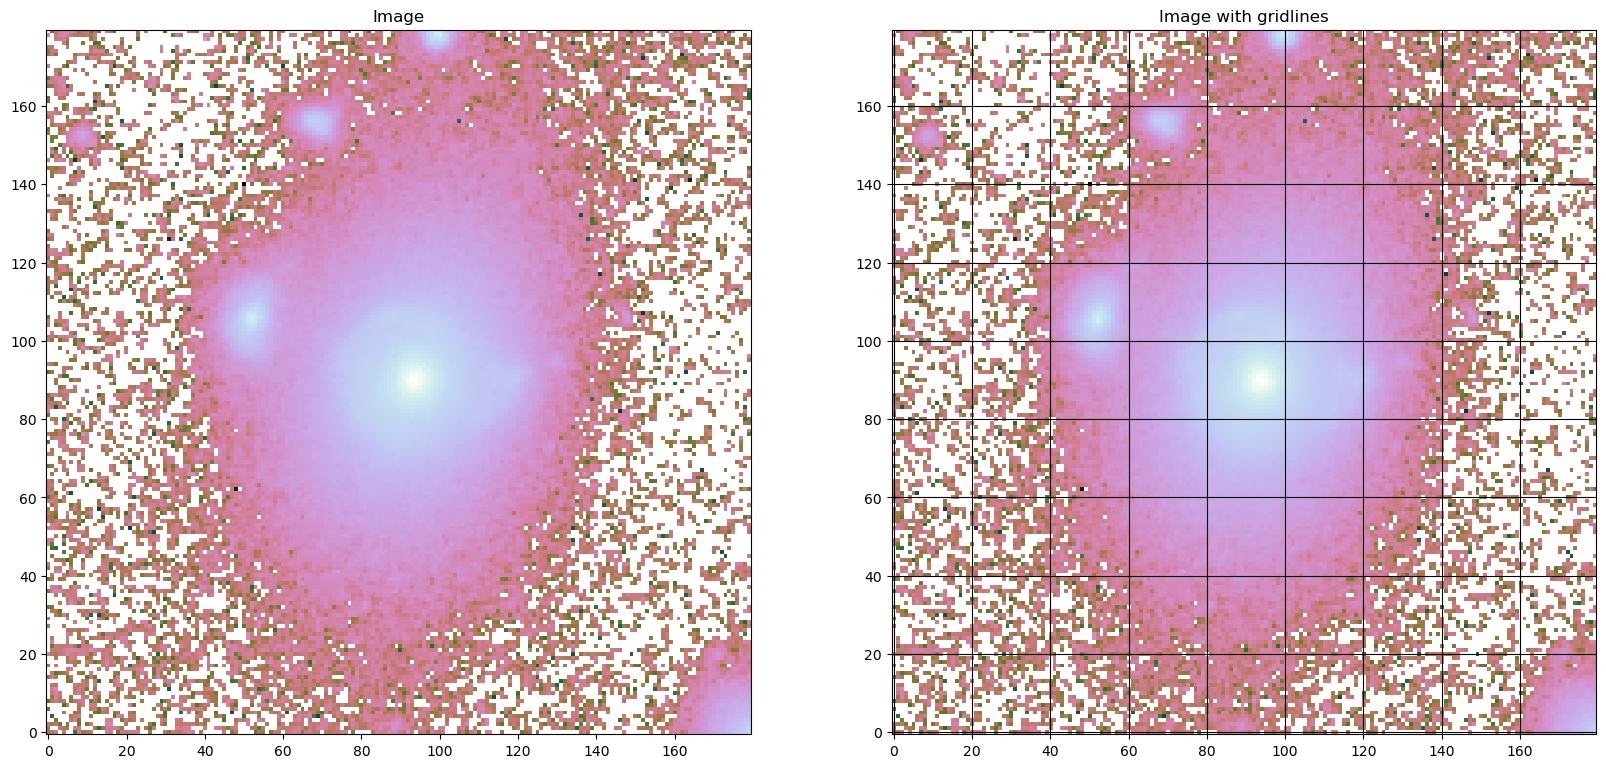

In [17]:
# extracting image_data from kwargs_data
image = kwargs_data["image_data"]

# Make the plot
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[0].set_title("Image")

axes[1].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[1].set_title("Image with gridlines")
axes[1].grid(True, color="black")

# Show the plots
plt.show()

## Creating Mask

In [18]:
# To make a mask using lenstronomy functions, here is an example code:


ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 7.5  # arcsecond
# b = 4
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 3,
    lens_center_dec + 1.2,
    1.2,
    2,
    np.pi / 6,
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.8,
    lens_center_dec + 5.1,
    0.7,
    0.7,
    0,
)
mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.7,
    lens_center_dec + 6.7,
    0.7,
    0.7,
    0,
)
mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.2,
    lens_center_dec + 0.23,
    0.3,
    0.3,
    0,
)
mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
)
mask[mask >= 1] = 1
mask[mask < 0] = 0

mask_img_1 = mask.reshape(num_pix, num_pix)

C:\Users\Gaming Beast\AppData\Local\Temp\ipykernel_912\1591348934.py:4: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
C:\Users\Gaming Beast\AppData\Local\Temp\ipykernel_912\1591348934.py:14: RuntimeWarning: divide by zero encountered in log10
  image_after_mask = np.log10(image * mask)
C:\Users\Gaming Beast\AppData\Local\Temp\ipykernel_912\1591348934.py:14: RuntimeWarning: invalid value encountered in log10
  image_after_mask = np.log10(image * mask)


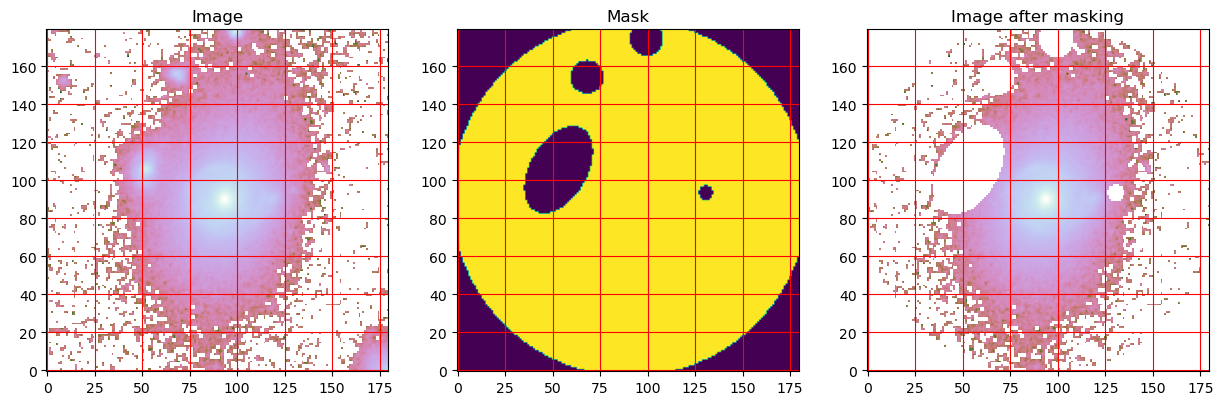

In [19]:
# Setting the subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[0].grid(True, color="red")
axes[0].set_title("Image")

mask = mask.reshape(num_pix, num_pix)

axes[1].imshow(mask, origin="lower")
axes[1].grid(True, color="red")
axes[1].set_title("Mask")

image_after_mask = np.log10(image * mask)

axes[2].imshow(image_after_mask, origin="lower", cmap="cubehelix")
axes[2].grid(True, color="red")
axes[2].set_title("Image after masking")
# Show the plots
plt.show()

## Lens Modeling with Lenstronomy

In [20]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

## Lens Galaxy's Mass Model

### EPL Parameters

In [21]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 1.53,
        "gamma": 1.7,
        "e1": -0.0534,
        "e2": -0.016,
        "center_x": -1.019,
        "center_y": -0.065,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.1,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 1,
        "gamma": 1.7,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 2.1,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

### Shear Parameters

In [22]:
fixed_lens.append({"ra_0": 0, "dec_0": 0})

kwargs_lens_init.append({"gamma1": -0.036, "gamma2": -0.028})
kwargs_lens_sigma.append({"gamma1": 0.01, "gamma2": 0.01})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

## Source Galaxy's Light Model

### Sersic Ellipse Parameters

In [23]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.0100,
        "n_sersic": 1,
        "e1": 0.319,
        "e2": 0.3198,
        "center_x": -0.7459,
        "center_y": -0.04071,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.001,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 1,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.2,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

### Shapelets Parameters

In [24]:
fixed_source.append({"n_max": 10})
kwargs_source_init.append({"center_x": -0.7459, "center_y": -0.04071, "beta": 0.04995})
kwargs_source_sigma.append({"center_x": 0.2, "center_y": 0.2, "beta": 0.001})
kwargs_lower_source.append({"center_x": -10, "center_y": -10, "beta": 0.001})
kwargs_upper_source.append({"center_x": 10, "center_y": 10, "beta": 0.05})

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

joint_shapelets_with_sersic = [[0, 1, ["center_x", "center_y"]]]

## Lens Galaxy's Light Model

### 1st Sersic Ellipse Parameters

In [25]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 1.8705,
        "n_sersic": 2,
        "e1": -0.1897,
        "e2": -0.115,
        "center_x": -0.255,
        "center_y": -0.0594,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

### 2nd Sersic Ellipse Parameters

In [26]:
fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5280,
        "n_sersic": 2,
        "e1": -0.0355,
        "e2": -0.0266,
        "center_x": -0.2554,
        "center_y": -0.059,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

In [27]:
# Combining all the above specification in the `kwargs_params` dictionary

kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_shapelets_with_sersic,
}

In [28]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

In [29]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band"
    # 'multi-linear': every imaging band
    # has independent solutions of the
    # surface brightness, 'joint-linear':
    # there is one joint solution of the
    # linear coefficients demanded across the bands.
}

## The Model Fitting

In [30]:
# using Particle Swarm Optimization
fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 100}]
]

fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    mpi=False,
    verbose=True,
)

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
]

fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list

kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs
output = [
    kwargs_result,
    multi_band_list_out,
    fit_output,
    kwargs_fixed_out,
]

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.9867111642357715 reduced X^2 of best position
-12491.763339224868 log likelihood
25320 effective number of data points
[{'theta_E': 1.5120254232449353, 'gamma': 1.7001307333329956, 'e1': 0.08223717784691768, 'e2': -0.02114439408790226, 'center_x': -1.018361229014797, 'center_y': -0.07275492075138783}, {'gamma1': 0.06200093597159231, 'gamma2': -0.028119235917232793, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.010264149452169134, 'n_sersic': 1.0, 'e1': 0.31194201612499967, 'e2': 0.3667911862765322, 'center_x': -0.683712443993426, 'center_y': -0.055379406765350914}, {'amp': 1, 'n_max': 10, 'beta': 0.049779192947501986, 'center_x': -0.683712443993426, 'center_y': -0.055379406765350914}] source result
[{'amp': 1, 'R_sersic': 1.8473936469335765, 'n_sersic': 1.0, 'e1': -0.19951181787133945, 'e2': -0.1217669101077803, 'center_x': -0.2563070006003676, 'center_y': -0.05941749245625826}, {'a

In [35]:
!pip install joblib

In [39]:
output_path = "./DESIJ0132-1600_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

## Visualizing the Fitted Model

-0.9831776236159471 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9831776236159471


C:\Users\Gaming Beast\AppData\Local\Temp\ipykernel_912\2660060914.py:18: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


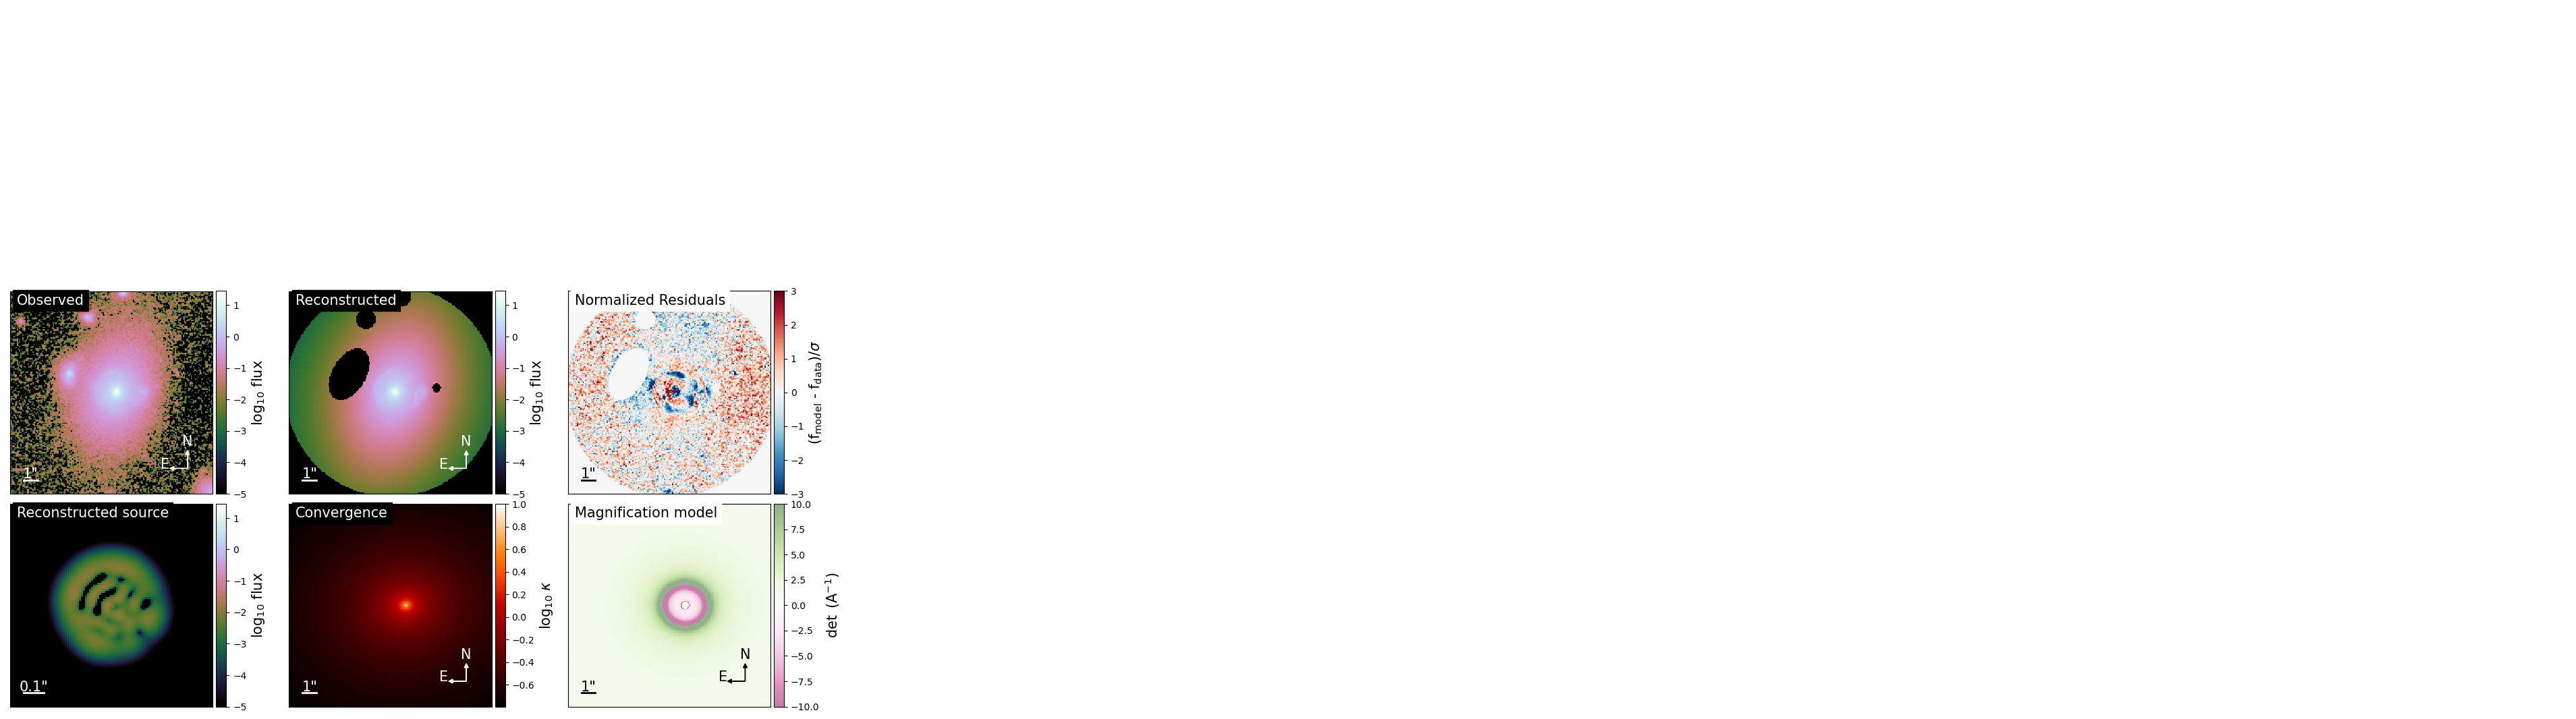

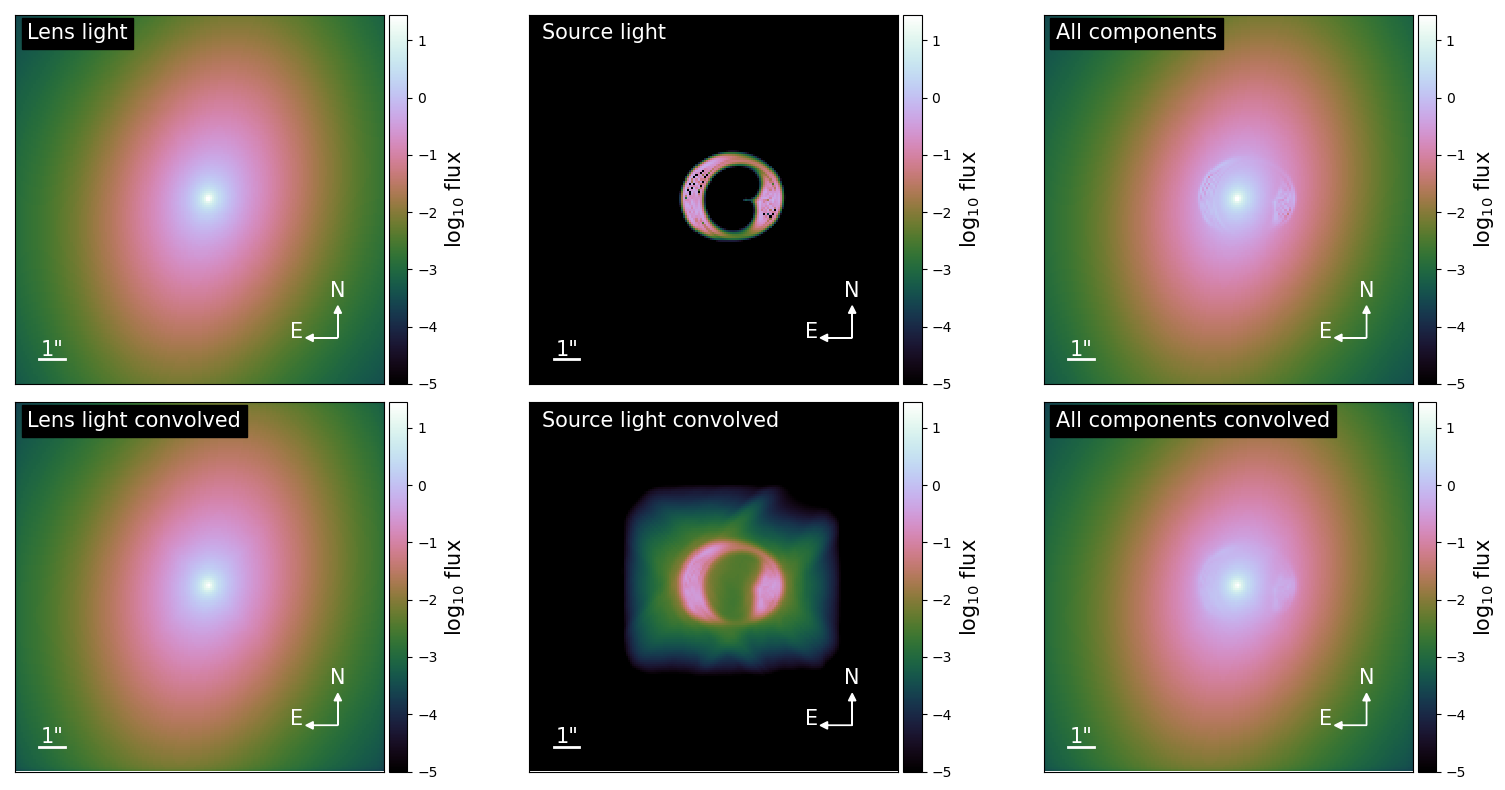

In [40]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()